In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagrasharma133/oasis-alzheimer-dataset")

print("Path to dataset files:", path)



Path to dataset files: /root/.cache/kagglehub/datasets/kushagrasharma133/oasis-alzheimer-dataset/versions/1


In [7]:
import os
import pandas as pd
import kagglehub
import io
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

# Mapeia os rótulos numéricos para nomes das classes (apenas para referência posterior)
label_map = {
    0: 'Mild_Dementia',
    1: 'Moderate_Dementia',
    2: 'Non_Demented',
    3: 'Very_mild_Dementia'
}

# Faz o download da versão mais recente do dataset via kagglehub
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

# Mapeia os nomes das pastas para rótulos numéricos
class_map = {
    'Mild Dementia': 0,
    'Moderate Dementia': 1,
    'Non Demented': 2,
    'Very mild Dementia': 3
}

# Cria um dataframe a partir das imagens contidas nas pastas
def criar_dataframe_de_imagens(base_path, class_map, source_name):
    dados = []
    for label_nome, label_id in class_map.items():
        pasta = os.path.join(base_path, label_nome)
        if not os.path.exists(pasta):
            continue
        for nome_arquivo in os.listdir(pasta):
            caminho_completo = os.path.join(pasta, nome_arquivo)
            dados.append({
                'image_path': caminho_completo,
                'label': label_id,
                'source': source_name
            })
    return pd.DataFrame(dados)

# Carrega os dados de imagem das pastas (OASIS)
df_train_oasis = criar_dataframe_de_imagens(
    '/kaggle/input/oasis-alzheimer-dataset/train', class_map, 'oasis_train')
df_test_oasis = criar_dataframe_de_imagens(
    '/kaggle/input/oasis-alzheimer-dataset/test', class_map, 'oasis_test')

# Carrega os dados do arquivo Parquet
df_parquet = pd.read_parquet('/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet')

# Converte os bytes da imagem em objetos BytesIO (necessário para abrir com PIL)
df_parquet['image_path'] = df_parquet['image'].apply(lambda x: BytesIO(x['bytes']))

# Seleciona apenas as colunas necessárias e adiciona a coluna 'source'
df_parquet_final = df_parquet[['image_path', 'label']].copy()
df_parquet_final['source'] = 'parquet'

# Junta os três dataframes em um único dataframe geral
df_geral = pd.concat([df_parquet_final, df_train_oasis, df_test_oasis], ignore_index=True)

# Mostra a distribuição de amostras por fonte
print("\nDistribuição por fonte no df_geral:\n", df_geral['source'].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

In [9]:
# Cirar dataset customizado
class AlzheimerUnifiedDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.df = dataframe
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    entrada = self.df.iloc[idx]['image_path']
    label = self.df.iloc[idx]['label']

    # Se for caminho (string), abra a imagem
    if isinstance(entrada, str):
      image = Image.open(entrada).convert('RGB')
    else:
      image = Image.open(entrada).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, label

In [10]:
# Split em treino, validação e teste
df_trainval, df_test = train_test_split(df_geral, test_size=0.15, stratify=df_geral['label'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.15, stratify=df_trainval['label'], random_state=42)

In [ ]:
# Transforms padrão
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Carregar os loaders
train_dataset = AlzheimerUnifiedDataset(df_train, transform=transform)
val_dataset = AlzheimerUnifiedDataset(df_val, transform=transform)
test_dataset = AlzheimerUnifiedDataset(df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Modelo com ResNet18 pré-treinada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carrega modelo pré-treinado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Adapta saída final para 4 classes
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)

model = model.to(device)

In [ ]:
# Função de perda com pesos
weights = torch.tensor([0.0825, 0.8802, 0.0067, 0.0305]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Treinamento
num_epochs = 10
train_losses, val_losses = [], []

star_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_train_true, y_train_pred = [], []

    for images, labels in tqdm(train_loader, desc=f'Época {epoch + 1}/{num_epochs} - Treino'):
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      # Métricas treino
      _, preds = torch.max(outputs, 1)
      y_train_true.extend(labels.cpu().numpy())
      y_train_pred.extend(preds.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted', zero_division=0)

    # Validação
    model.eval()
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    with torch.no_grad():
      for images, labels in tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} - Validação'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Métricas validação
        _, preds = torch.max(outputs, 1)
        y_val_true.extend(labels.cpu().numpy())
        y_val_pred.extend(preds.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    print(f"""
    Época {epoch+1}/{num_epochs}
    ----------------------------
    Treino:
    Loss: {avg_train_loss:.4f}
    Acurácia: {train_accuracy:.4f}
    Precisão: {train_precision:.4f}
    Recall: {train_recall:.4f}
    F1 Score: {train_f1:.4f}
    Validação:
    Loss: {avg_val_loss:.4f}
    Acurácia: {val_accuracy:.4f}
    Precisão: {val_precision:.4f}
    Recall: {val_recall:.4f}
    F1 Score: {val_f1:.4f}
    """)

end_time = time.time()
execution_time = end_time - star_time
print(f"Tempo de execução: {execution_time} segundos")

In [ ]:
from sklearn.metrics import confusion_matrix

# Matriz de confusão para treino
cm_train = confusion_matrix(y_train_true, y_train_pred)
print("Matriz de Confusão - Treino:")
print(cm_train)

# Matriz de confusão para validação
cm_val = confusion_matrix(y_val_true, y_val_pred)
print("\nMatriz de Confusão - Validação:")
print(cm_val)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusão - Treino
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(label_map.values()))
disp_train.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Treino")
plt.tight_layout()
plt.show()

# Matriz de confusão - Validação
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=list(label_map.values()))
disp_val.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão - Validação")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from collections import Counter

# Conta os rótulos no dataset completo (ou só no treino, se preferir)
labels_all = df_geral['label'].values  # ou apenas y_train, se já separado
class_counts = Counter(labels_all)

# Número total de amostras
total_samples = sum(class_counts.values())

# Calcula pesos inversamente proporcionais
class_weights = []
for i in range(len(label_map)):  # 4 classes
    freq = class_counts[i] / total_samples
    weight = 1.0 / freq
    class_weights.append(weight)

# Normaliza para evitar números grandes
class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum()

print("Contagem por classe:", class_counts)
print("Pesos normalizados por classe:", class_weights)


# Converte para tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Cria o criterion ponderado
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Baixando Alzheimer MRI dataset...


100%|██████████| 26.0M/26.0M [00:00<00:00, 208MB/s]

Extracting model files...


Alzheimer MRI baixado para: /root/.cache/kagglehub/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/versions/1
Baixando OASIS dataset...


100%|██████████| 1.23G/1.23G [00:06<00:00, 215MB/s]

Extracting model files...


OASIS baixado para: /root/.cache/kagglehub/datasets/kushagrasharma133/oasis-alzheimer-dataset/versions/1
Carregando Alzheimer MRI Parquet...
Parquet carregado com 5120 linhas
Carregando OASIS dataset...
OASIS train: 69148 imagens
OASIS test: 17289 imagens

Distribuição por fonte no df_geral:
source
oasis_train          69148
oasis_test           17289
alzheimer_parquet     5120
Name: count, dtype: int64

Total de imagens: 91557
Dispositivo: cuda
Contagem por classe: Counter({2: 69788, 3: 15506, 0: 5726, 1: 537})
Pesos normalizados por classe: [0.0825473  0.88019705 0.00677288 0.03048277]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 
Época 1/10 - Validação: 100%|██████████| 730/730 [00:24<00:00, 29.30it/s]



    Época 1/10
    ----------------------------
    Treino:
    Loss: 0.3022
    Acurácia: 0.8913
    Precisão: 0.9119
    Recall: 0.8913
    F1 Score: 0.8975
    Validação:
    Loss: 0.1392
    Acurácia: 0.9360
    Precisão: 0.9474
    Recall: 0.9360
    F1 Score: 0.9389
    


Época 2/10 - Validação: 100%|██████████| 730/730 [00:24<00:00, 30.22it/s]



    Época 2/10
    ----------------------------
    Treino:
    Loss: 0.1502
    Acurácia: 0.9506
    Precisão: 0.9560
    Recall: 0.9506
    F1 Score: 0.9522
    Validação:
    Loss: 0.0749
    Acurácia: 0.9702
    Precisão: 0.9731
    Recall: 0.9702
    F1 Score: 0.9709
    


Época 3/10 - Validação: 100%|██████████| 730/730 [00:23<00:00, 30.45it/s]



    Época 3/10
    ----------------------------
    Treino:
    Loss: 0.0948
    Acurácia: 0.9654
    Precisão: 0.9680
    Recall: 0.9654
    F1 Score: 0.9661
    Validação:
    Loss: 0.0535
    Acurácia: 0.9747
    Precisão: 0.9767
    Recall: 0.9747
    F1 Score: 0.9752
    


Época 4/10 - Validação: 100%|██████████| 730/730 [00:24<00:00, 29.84it/s]



    Época 4/10
    ----------------------------
    Treino:
    Loss: 0.0583
    Acurácia: 0.9764
    Precisão: 0.9777
    Recall: 0.9764
    F1 Score: 0.9767
    Validação:
    Loss: 0.0584
    Acurácia: 0.9882
    Precisão: 0.9885
    Recall: 0.9882
    F1 Score: 0.9882
    


Época 5/10 - Validação: 100%|██████████| 730/730 [00:24<00:00, 29.68it/s]



    Época 5/10
    ----------------------------
    Treino:
    Loss: 0.0511
    Acurácia: 0.9807
    Precisão: 0.9817
    Recall: 0.9807
    F1 Score: 0.9810
    Validação:
    Loss: 0.0318
    Acurácia: 0.9877
    Precisão: 0.9880
    Recall: 0.9877
    F1 Score: 0.9878
    


Época 6/10 - Validação: 100%|██████████| 730/730 [00:23<00:00, 30.47it/s]



    Época 6/10
    ----------------------------
    Treino:
    Loss: 0.0349
    Acurácia: 0.9862
    Precisão: 0.9867
    Recall: 0.9862
    F1 Score: 0.9863
    Validação:
    Loss: 0.0313
    Acurácia: 0.9916
    Precisão: 0.9917
    Recall: 0.9916
    F1 Score: 0.9916
    


Época 7/10 - Validação: 100%|██████████| 730/730 [00:23<00:00, 30.54it/s]



    Época 7/10
    ----------------------------
    Treino:
    Loss: 0.0300
    Acurácia: 0.9900
    Precisão: 0.9902
    Recall: 0.9900
    F1 Score: 0.9900
    Validação:
    Loss: 0.0419
    Acurácia: 0.9919
    Precisão: 0.9919
    Recall: 0.9919
    F1 Score: 0.9919
    


Época 8/10 - Validação: 100%|██████████| 730/730 [00:24<00:00, 29.87it/s]



    Época 8/10
    ----------------------------
    Treino:
    Loss: 0.0173
    Acurácia: 0.9933
    Precisão: 0.9934
    Recall: 0.9933
    F1 Score: 0.9933
    Validação:
    Loss: 0.0336
    Acurácia: 0.9951
    Precisão: 0.9951
    Recall: 0.9951
    F1 Score: 0.9951
    


Época 9/10 - Validação: 100%|██████████| 730/730 [00:23<00:00, 31.01it/s]



    Época 9/10
    ----------------------------
    Treino:
    Loss: 0.0167
    Acurácia: 0.9941
    Precisão: 0.9942
    Recall: 0.9941
    F1 Score: 0.9942
    Validação:
    Loss: 0.0569
    Acurácia: 0.9866
    Precisão: 0.9872
    Recall: 0.9866
    F1 Score: 0.9867
    


Época 10/10 - Validação: 100%|██████████| 730/730 [00:23<00:00, 30.94it/s]



    Época 10/10
    ----------------------------
    Treino:
    Loss: 0.0213
    Acurácia: 0.9933
    Precisão: 0.9934
    Recall: 0.9933
    F1 Score: 0.9933
    Validação:
    Loss: 0.0158
    Acurácia: 0.9960
    Precisão: 0.9960
    Recall: 0.9960
    F1 Score: 0.9960
    
Tempo de execução: 2883.88 segundos
Matriz de Confusão - Treino:
[[ 4121     4     4     8]
 [    0   385     1     2]
 [   67    19 50084   251]
 [   28     8    52 11115]]

Matriz de Confusão - Validação:
[[ 726    0    0    4]
 [   0   68    0    0]
 [   4    0 8881   14]
 [   9    0   16 1952]]


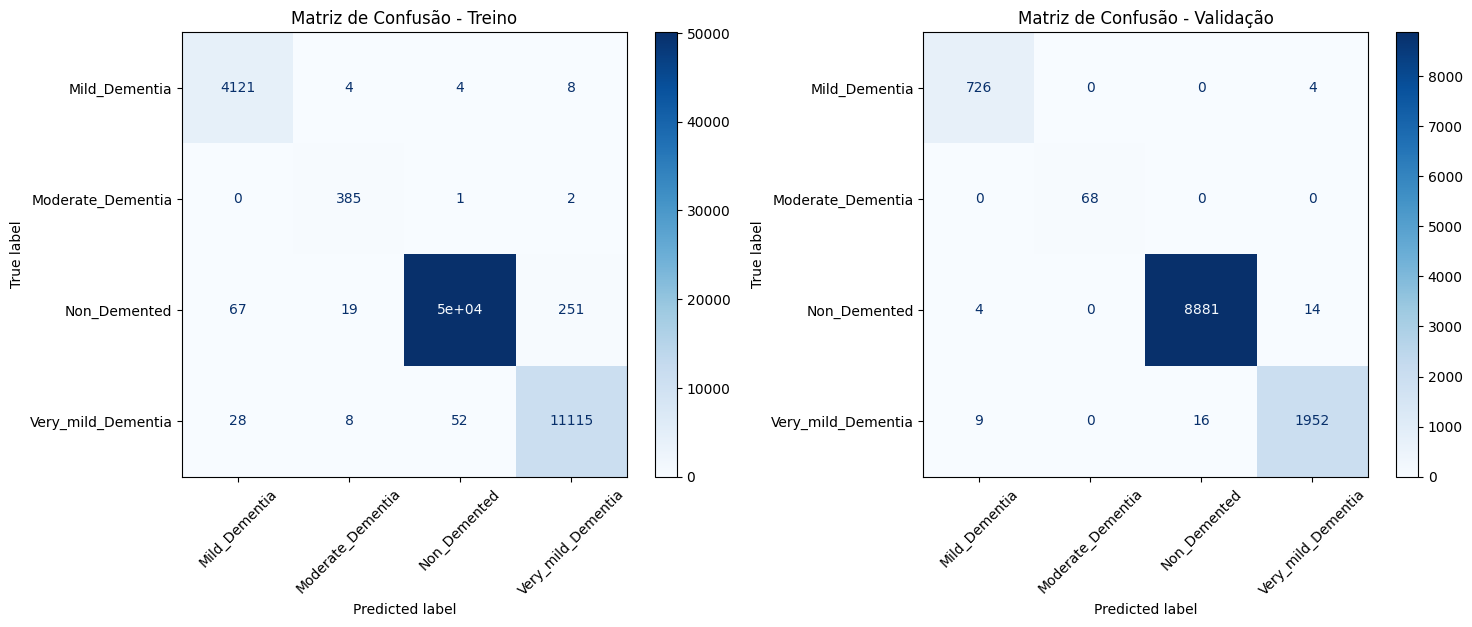

Treinamento concluído com sucesso!


In [1]:
import kagglehub
import os
import pandas as pd
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Mapeia os rótulos numéricos para nomes das classes
label_map = {
    0: 'Mild_Dementia',
    1: 'Moderate_Dementia',
    2: 'Non_Demented',
    3: 'Very_mild_Dementia'
}

# Faz o download dos datasets via kagglehub
print("Baixando Alzheimer MRI dataset...")
path_alzheimer = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")
print(f"Alzheimer MRI baixado para: {path_alzheimer}")

print("Baixando OASIS dataset...")
path_oasis = kagglehub.dataset_download("kushagrasharma133/oasis-alzheimer-dataset")
print(f"OASIS baixado para: {path_oasis}")

# Mapeia os nomes das pastas para rótulos numéricos
class_map = {
    'Mild Dementia': 0,
    'Moderate Dementia': 1,
    'Non Demented': 2,
    'Very mild Dementia': 3
}

# Cria um dataframe a partir das imagens contidas nas pastas
def criar_dataframe_de_imagens(base_path, class_map, source_name):
    dados = []
    for label_nome, label_id in class_map.items():
        pasta = os.path.join(base_path, label_nome)
        if not os.path.exists(pasta):
            print(f"Pasta não encontrada: {pasta}")
            continue
        for nome_arquivo in os.listdir(pasta):
            if nome_arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
                caminho_completo = os.path.join(pasta, nome_arquivo)
                dados.append({
                    'image_path': caminho_completo,
                    'label': label_id,
                    'source': source_name
                })
    return pd.DataFrame(dados)

# Carrega os dados do arquivo Parquet do Alzheimer MRI
print("Carregando Alzheimer MRI Parquet...")
parquet_files = []
for root, dirs, files in os.walk(path_alzheimer):
    for file in files:
        if file.endswith('.parquet') and 'train' in file:
            parquet_files.append(os.path.join(root, file))

if parquet_files:
    df_parquet = pd.read_parquet(parquet_files[0])
    print(f"Parquet carregado com {len(df_parquet)} linhas")
    
    # Converte os bytes da imagem em objetos BytesIO
    df_parquet['image_path'] = df_parquet['image'].apply(lambda x: BytesIO(x['bytes']))
    df_parquet_final = df_parquet[['image_path', 'label']].copy()
    df_parquet_final['source'] = 'alzheimer_parquet'
else:
    print("Nenhum arquivo Parquet encontrado!")
    df_parquet_final = pd.DataFrame(columns=['image_path', 'label', 'source'])

# Carrega os dados OASIS do caminho correto (usando o path baixado)
print("Carregando OASIS dataset...")
df_train_oasis = criar_dataframe_de_imagens(
    os.path.join(path_oasis, 'train'), class_map, 'oasis_train')
df_test_oasis = criar_dataframe_de_imagens(
    os.path.join(path_oasis, 'test'), class_map, 'oasis_test')

print(f"OASIS train: {len(df_train_oasis)} imagens")
print(f"OASIS test: {len(df_test_oasis)} imagens")

# Junta todos os dataframes
df_geral = pd.concat([df_parquet_final, df_train_oasis, df_test_oasis], ignore_index=True)

# Mostra a distribuição de amostras por fonte
print("\nDistribuição por fonte no df_geral:")
print(df_geral['source'].value_counts())
print(f"\nTotal de imagens: {len(df_geral)}")

# Dataset customizado
class AlzheimerUnifiedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        entrada = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        # Se for caminho (string), abra a imagem
        if isinstance(entrada, str):
            image = Image.open(entrada).convert('RGB')
        else:
            # Se for BytesIO (do Parquet)
            entrada.seek(0)  # Volta para o início do buffer
            image = Image.open(entrada).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Split em treino, validação e teste
df_trainval, df_test = train_test_split(df_geral, test_size=0.15, stratify=df_geral['label'], random_state=42)
df_train, df_val = train_test_split(df_trainval, test_size=0.15, stratify=df_trainval['label'], random_state=42)

# Transforms padrão
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar os datasets
train_dataset = AlzheimerUnifiedDataset(df_train, transform=transform)
val_dataset = AlzheimerUnifiedDataset(df_val, transform=transform)
test_dataset = AlzheimerUnifiedDataset(df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Calcula pesos das classes
labels_all = df_geral['label'].values
class_counts = Counter(labels_all)
total_samples = sum(class_counts.values())

class_weights = []
for i in range(len(label_map)):
    freq = class_counts[i] / total_samples
    weight = 1.0 / freq if freq > 0 else 1.0
    class_weights.append(weight)

# Normaliza os pesos
class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum()

print("Contagem por classe:", class_counts)
print("Pesos normalizados por classe:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Modelo com ResNet18 pré-treinada
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

# Função de perda com pesos
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Treinamento
num_epochs = 10
train_losses, val_losses = [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_train_true, y_train_pred = [], []

    for images, labels in tqdm(train_loader, desc=f'Época {epoch + 1}/{num_epochs} - Treino'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Métricas treino
        _, preds = torch.max(outputs, 1)
        y_train_true.extend(labels.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted', zero_division=0)

    # Validação
    model.eval()
    val_loss = 0.0
    y_val_true, y_val_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} - Validação'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Métricas validação
            _, preds = torch.max(outputs, 1)
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    val_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted', zero_division=0)

    print(f"""
    Época {epoch+1}/{num_epochs}
    ----------------------------
    Treino:
    Loss: {avg_train_loss:.4f}
    Acurácia: {train_accuracy:.4f}
    Precisão: {train_precision:.4f}
    Recall: {train_recall:.4f}
    F1 Score: {train_f1:.4f}
    Validação:
    Loss: {avg_val_loss:.4f}
    Acurácia: {val_accuracy:.4f}
    Precisão: {val_precision:.4f}
    Recall: {val_recall:.4f}
    F1 Score: {val_f1:.4f}
    """)

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.2f} segundos")

# Matriz de confusão
cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_val = confusion_matrix(y_val_true, y_val_pred)

print("Matriz de Confusão - Treino:")
print(cm_train)
print("\nMatriz de Confusão - Validação:")
print(cm_val)

# Plot das matrizes de confusão
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(label_map.values()))
disp_train.plot(cmap=plt.cm.Blues, ax=ax1, xticks_rotation=45)
ax1.set_title("Matriz de Confusão - Treino")

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=list(label_map.values()))
disp_val.plot(cmap=plt.cm.Blues, ax=ax2, xticks_rotation=45)
ax2.set_title("Matriz de Confusão - Validação")

plt.tight_layout()
plt.show()

print("Treinamento concluído com sucesso!")